In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from scipy.spatial.transform import Rotation
import quaternion
from scipy.interpolate import griddata

In [2]:
def get_color(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    color_path = os.path.join(folder, "0", f"{side}_rgb", str(frame_index) + ".jpg")
    color = cv2.imread(color_path, -1)

    if do_flip:
        color = color.transpose(pil.FLIP_LEFT_RIGHT)

    return color

def get_depth(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    depth_path = os.path.join(folder, "0", f"{side}_depth", str(frame_index) + ".png")
    depth = cv2.imread(depth_path, -1).astype(np.float32) * 10 / 65535

    if do_flip:
        depth = np.fliplr(depth)

    return depth

def get_semantics(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    seg_path = os.path.join(folder, "0", f"{side}_semantic", str(frame_index) + ".npy")
    seg = np.load(seg_path)

    if do_flip:
        seg = np.fliplr(seg)

    return seg

def get_pose(folder, frame_index, side, do_flip):
    # Refer to registration_test notebook.
    
    cam_to_agent = np.eye(4)
    cam_to_agent[1,1] = -1  # Flip the y-axis of the point-cloud to be pointing upwards
    cam_to_agent[2,2] = -1  # Flip the z-axis of the point-cloud to follow right-handed coordinate system.
    
    if side == 'r':
        cam_to_agent[:3, 3] = np.array([baseline/2, cam_height, 0])
    else:
        cam_to_agent[:3, 3] = np.array([-baseline/2, cam_height, 0])

    pose_path = os.path.join(folder, "0", "pose", str(frame_index) + ".npy")
    agent_pose = np.load(pose_path, allow_pickle=True).item()

    rot = Rotation.from_quat([agent_pose['rotation'].x, agent_pose['rotation'].y, 
                            agent_pose['rotation'].z, agent_pose['rotation'].w])
    R = np.eye(4)
    R[:3, :3] = rot.as_matrix()

    T = np.eye(4)
    T[:3, 3] = agent_pose['position']
    
    M = (T @ R @ cam_to_agent).astype(np.float32)

    # The images will already be locally flipped. 
    # We need to only flip the camera's global x-coordinate.
    # Refer to registration_notebook.
    M[0,3] *= (1 - 2*do_flip)

    return M

In [3]:
def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

def img_to_rect( u, v, depth_rect, P2):
    
    cu = P2[0, 2]
    cv = P2[1, 2]
    fu = P2[0, 0]
    fv = P2[1, 1]

    x = ((u - cu) * depth_rect) / fu
    y = ((v - cv) * depth_rect) / fv
    pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
    return pts_rect

def img_to_lid(depth_map, cam_mat, label=None):

    x_range = np.arange(0, depth_map.shape[1])
    y_range = np.arange(0, depth_map.shape[0])
    x_idxs, y_idxs = np.meshgrid(x_range, y_range)
    x_idxs, y_idxs = x_idxs.reshape(-1), y_idxs.reshape(-1)

    depth = depth_map[y_idxs, x_idxs]
    pts_rect = img_to_rect(x_idxs, y_idxs, depth, cam_mat)
    
    if label is not None:
        label_intensity = label[y_idxs, x_idxs]
        filt = label_intensity == 2
        pts_rect = pts_rect[filt]

    return pts_rect

In [4]:
baseline = 0.2
cam_height = 1.0
K = camera_intrinsic_transform(f_x=320, c_x=320, f_y=320, c_y=240)

data_dir = '/scratch/shantanu.singh/habitat_data/HabitatVal/'
os.listdir(data_dir)

['TbHJrupSAjP',
 'zsNo4HB9uLZ',
 'X7HyMhZNoso',
 'oLBMNvg9in8',
 'EU6Fwq7SyZv',
 'x8F5xyUWy9e',
 'Z6MFQCViBuw',
 'pLe4wQe7qrG',
 'QUCTc6BB5sX',
 '8194nk5LbLH',
 '2azQ1b91cZZ']

In [5]:
scene = 'oLBMNvg9in8'
scene_dir = os.path.join(data_dir, scene)

[  0.         -18.62362239   0.        ] [ 0.00523633  0.         -0.03193498]


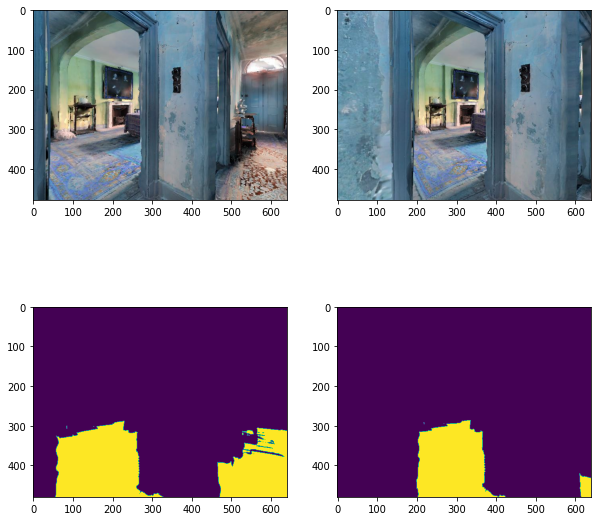

In [6]:
idx_s = 55 # source
idx_t = 57 # target

color_s = get_color(scene_dir, idx_s, 'l', False)
color_t = get_color(scene_dir, idx_t, 'l', False)

depth_s = get_depth(scene_dir, idx_s, 'l', False)
depth_t = get_depth(scene_dir, idx_t, 'l', False)

seg_s = get_semantics(scene_dir, idx_s, 'l', False)
seg_t = get_semantics(scene_dir, idx_t, 'l', False)

pose_s = get_pose(scene_dir, idx_s, 'l', False)
pose_t = get_pose(scene_dir, idx_t, 'l', False)
T = np.linalg.inv(pose_s) @ pose_t

print(np.rad2deg(Rotation.from_matrix(T[:3, :3]).as_rotvec()), T[:3, 3])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax[0][0].imshow(color_s)
ax[1][0].imshow(seg_s==2)
ax[0][1].imshow(color_t)
ax[1][1].imshow(seg_t==2)

plt.show()

In [7]:
def get_bev(depth, seg, K, bev_shape, bev_res):
    h, w = depth.shape
    pc = img_to_lid(depth, K)      # .reshape((h,w,3))
    X = np.concatenate([pc, np.ones((h*w, 1))], axis=1)
    
    bw, bh = bev_shape
    res = bev_res
    
    Kb = np.eye(4)
    Kb[0, 0] = 1/res
    Kb[1, 1] = 1/res
    Kb[0, 3] = bw/2
    Kb[1, 3] = bh/2

    Tb = np.eye(4)
    Tb[:3, 3] = [0, 0, -(res*bh + 0.1)/2]  # to move to center of grid of range 0.1 to bh*res along z.

    Rb = np.eye(4)
    Rb[:3, :3] = Rotation.from_rotvec([np.pi/2, 0, 0]).as_matrix()

    Xb = (Kb @ Rb @ Tb @ X.T).T

    valid_idx = ((Xb[:, 1] >= 0) & (Xb[:, 1] < bh) & 
                 (Xb[:, 0] >= 0) & (Xb[:, 0] < bw) &
                 (Xb[:, 2] >= 0))

    u = np.round(Xb[:, 0][valid_idx]).astype(np.uint16)
    v = np.round(Xb[:, 1][valid_idx]).astype(np.uint16)
    z = Xb[valid_idx]
    
    grid_seg = (seg.reshape(-1)[valid_idx] == 2) + 1

    grid_idx = v * bw + u

    grid = np.zeros((bh, bw), dtype=np.uint8).reshape(-1)
    grid[grid_idx] = grid_seg

    grid = grid.reshape((bh, bw))
    
    return grid

Target to source


(array([  0.        , -18.62362239,   0.        ]),
 array([ 0.00523633,  0.        , -0.03193498], dtype=float32))

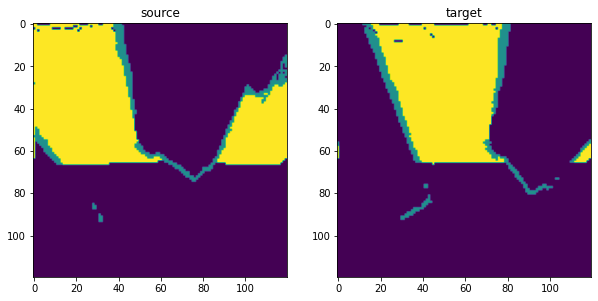

In [8]:
bev_shape = (120, 120) # w,h
bev_res = 0.025  # 1 pixel = 2.5 cm

bev_s = get_bev(depth_s, seg_s, K, bev_shape, bev_res)
bev_t = get_bev(depth_t, seg_t, K, bev_shape, bev_res)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(bev_s)
ax[0].set_title('source')
ax[1].imshow(bev_t)
ax[1].set_title('target')

print('Target to source')
np.rad2deg(Rotation.from_matrix(T[:3, :3]).as_rotvec()), T[:3, 3]

In [9]:
bw, bh = bev_shape
res = bev_res

tbx, tby = np.meshgrid(np.arange(bw),np.arange(bh))
tbz = np.ones_like(tbx)

tXb = np.stack([tbx, tby, tbz, np.ones_like(tbx)]).reshape((4, -1))  # 4 x n_points

Kb = np.eye(4)
Kb[0, 0] = 1/res
Kb[1, 1] = 1/res
Kb[0, 3] = bw/2
Kb[1, 3] = bh/2

Tb = np.eye(4)
Tb[:3, 3] = [0, 0, -(res*bh + 0.1)/2]  # to move to center of grid of range 0.1 to bh*res along z.

Rb = np.eye(4)
Rb[:3, :3] = Rotation.from_rotvec([np.pi/2, 0, 0]).as_matrix()

tXp = np.linalg.inv(Kb @ Rb @ Tb) @ tXb
tseg = bev_t.reshape(-1)

# h, w = depth_t.shape
# pc = img_to_lid(depth_t, K)      # .reshape((h,w,3))
# tXp = np.concatenate([pc, np.ones((h*w, 1))], axis=1).T
# tseg = (seg_t.reshape(-1) == 2) * 127 + 128

sXb = ((Kb @ Rb @ Tb) @ T @ tXp).T  # n_points x 4

Text(0.5, 1.0, 'source_rc')

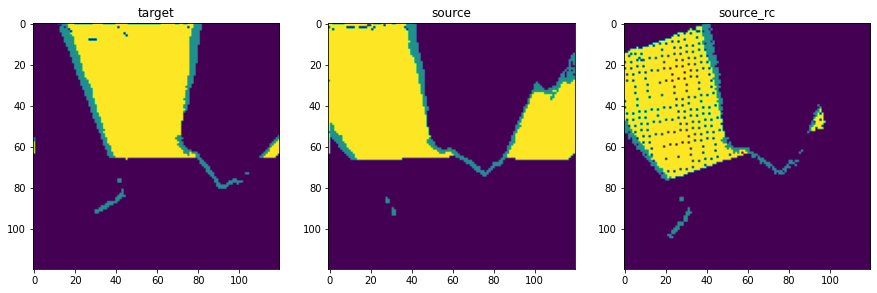

In [10]:
valid_idx = ((sXb[:, 1] >= 0) & (sXb[:, 1] < bh) & 
             (sXb[:, 0] >= 0) & (sXb[:, 0] < bw) &
             (sXb[:, 2] >= 0))

u = sXb[:, 0][valid_idx].astype(np.uint16)
v = sXb[:, 1][valid_idx].astype(np.uint16)

grid_idx = v * bw + u

grid = np.zeros((bh, bw), dtype=np.uint8).reshape(-1)
grid[grid_idx] = tseg[valid_idx]

grid = grid.reshape((bh, bw))

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(bev_t)
ax[0].set_title('target')
ax[1].imshow(bev_s)
ax[1].set_title('source')
ax[2].imshow(grid)
ax[2].set_title('source_rc')

Text(0.5, 1.0, 'target_rc')

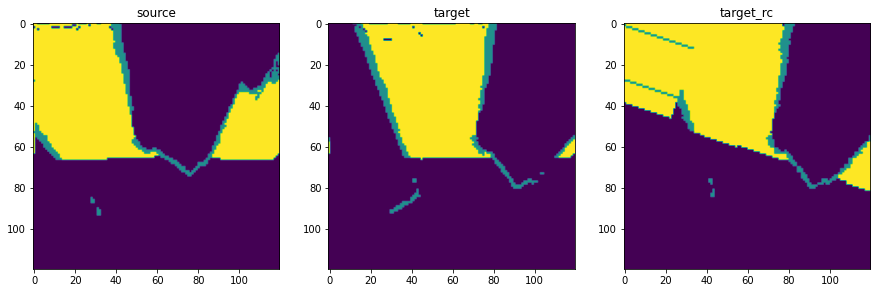

In [11]:
points = np.indices((bh, bw)).transpose((1,2,0)).reshape((-1, 2))
colors = bev_s.reshape(-1)
sample = sXb[:,:2]

sample_x = np.clip(sample[:, 0], 0, bw-1)  # Clamping to avoid nan in scipy griddata
sample_y = np.clip(sample[:, 1], 0, bh-1)  # Clamping to avoid nan in scipy griddata

color_rc = griddata(points, colors, (sample_y, sample_x), method='nearest')

color_rc = color_rc.reshape((bh, bw))
color_rc = np.round(color_rc).astype(np.uint8)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(bev_s)
ax[0].set_title('source')
ax[1].imshow(bev_t)
ax[1].set_title('target')
ax[2].imshow(color_rc)
ax[2].set_title('target_rc')

In [12]:
idx = bev_t==0
np.linalg.norm(bev_t[idx] - color_rc[idx], ord=1)* 100/(255 * np.sum(idx))

10.419338566446383

In [13]:
loss = nn.CrossEntropyLoss()
input_t = torch.from_numpy(color_rc.reshape(-1).astype(int))
input_t = nn.functional.one_hot(input_t).float()
target_t = torch.from_numpy(bev_t.reshape(-1).astype(int))
print(input_t.shape, target_t.shape)
output = loss(input_t, target_t)

print(output)

torch.Size([14400, 3]) torch.Size([14400])
tensor(0.6637)


### Understanding how to work with CE Loss for batches

In [14]:
loss = nn.CrossEntropyLoss(reduction='none')

input_t = torch.from_numpy(np.random.randint(low=0, high=3, size=(100,120,120)))
x = nn.functional.one_hot(input_t).float()
x = x.permute(0,3,1,2)

target_t = torch.from_numpy(np.random.randint(low=0, high=3, size=(100,120,120)))
print(x.shape, target_t.shape)
output = loss(x, target_t)

print(output.shape)

torch.Size([100, 3, 120, 120]) torch.Size([100, 120, 120])
torch.Size([100, 120, 120])


torch.Size([1, 120, 120])
torch.Size([1, 3, 120, 120])
tensor(0.)


/home/shantanu.singh/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


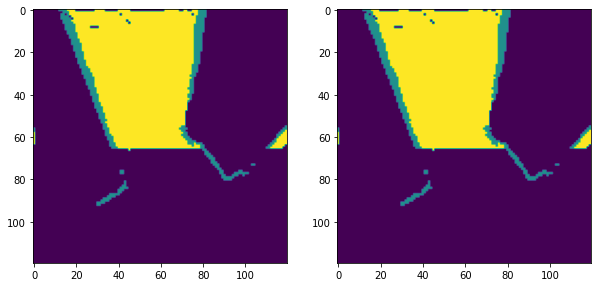

In [18]:
loss = nn.NLLLoss(reduction='none')

b1 = bev_t.copy()
b1 = torch.from_numpy(b1).unsqueeze(dim=0).long()
print(b1.shape)

b2 = nn.functional.one_hot(b1).float() * 100
b2 = b2.permute(0,3,1,2)
print(b2.shape)

b2 = nn.LogSoftmax()(b2)

print(loss(b2, b1).mean())

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(b1[0, ...])
ax[1].imshow(b2[0, ...].argmax(dim=0))